# Grafische Darstellung der Inzidenzen in BW

Hier käme noch Text zur Erklärung...

In [59]:
import pandas as pd               # Pandas ist eine Bibliothek zur Analys verschiedener Datenstrukturen
import numpy as np                # numpy ist eine Bilbiothek zur array Manipulation so wie MatLab
import matplotlib.pyplot as plt   # matplotlib ist für Grafik
from datetime import datetime     # Für das Datum: to be used in a string for filenames

In [60]:
# Diese URL die Daten, die vom "Ministerium für Soziales, 
# Gesundheit und Integration Baden-Württemberg" veröffentlicht werden
url = 'https://sozialministerium.baden-wuerttemberg.de/fileadmin/redaktion/m-sm/intern/downloads/Downloads_Gesundheitsschutz/Tabelle_Coronavirus-Faelle-BW.xlsx'
# Einlesen der excel Datei in einen pandas dataframe
#df_excel = pd.read_excel('Tabelle_Coronavirus-Faelle-BW-5.xlsx',na_filter=False)
df_excel = pd.read_excel(url,na_filter=False)
#
now = datetime.now()   # heutiges Datum und Urhzeit
datum = now.strftime("%Y%m%d")  # Extrahiere Jahr, Monat, Tag
df_excel.to_excel('CoronafaelleBW'+datum+'.xlsx',sheet_name='Cases')  # Sichere das von der URL gelesene File
# 
data = df_excel.to_numpy()[6:-3]  # Konvertiere Pandas Dataframe zu einem numpy array
data[data == ''] = '0'  # Setze die leeren Einträge auf den String '0'
#
ni,nj = data[:,1:].shape  # Shape des array (am 5.3.2022 z.B. (44,721))
data_int = np.array([[int(z) for z in data[i,1:]] for i in np.arange(ni)])  # Wandle die Stringeinträge in int um
data_dict = dict(zip(data[:,0],data_int))  # Mache einen Dictionary aus Daten und Kreisnamen
#
dfEWZ_csv = pd.read_csv('EWZLandkreise.csv',header=None, sep=';',na_filter=False)  # Einwohnerzahl der Kreise
dict_EWZkreise = dict(dfEWZ_csv.to_numpy())   # Dictionary der Einwohnerzahlen und Kreise

In [61]:

def keyString(partKey,dictionary):
    '''
    Diese Funktion gibt uns den korrekten key zurück, um in den dictionaries 
    nach values zu suchen. Die Funktion verlangt als Eingabe einen String und 
    einen dict.
    Returnvalue ist der korrekte Keyname.
    Bsp: 
    > keyString('Ulm',data_dict)
    > 'Ulm (Stadtkreis)'
    '''
    for key in dictionary.keys(): 
        if key.startswith(partKey): searchkey = key
    return searchkey

<IPython.core.display.Javascript object>


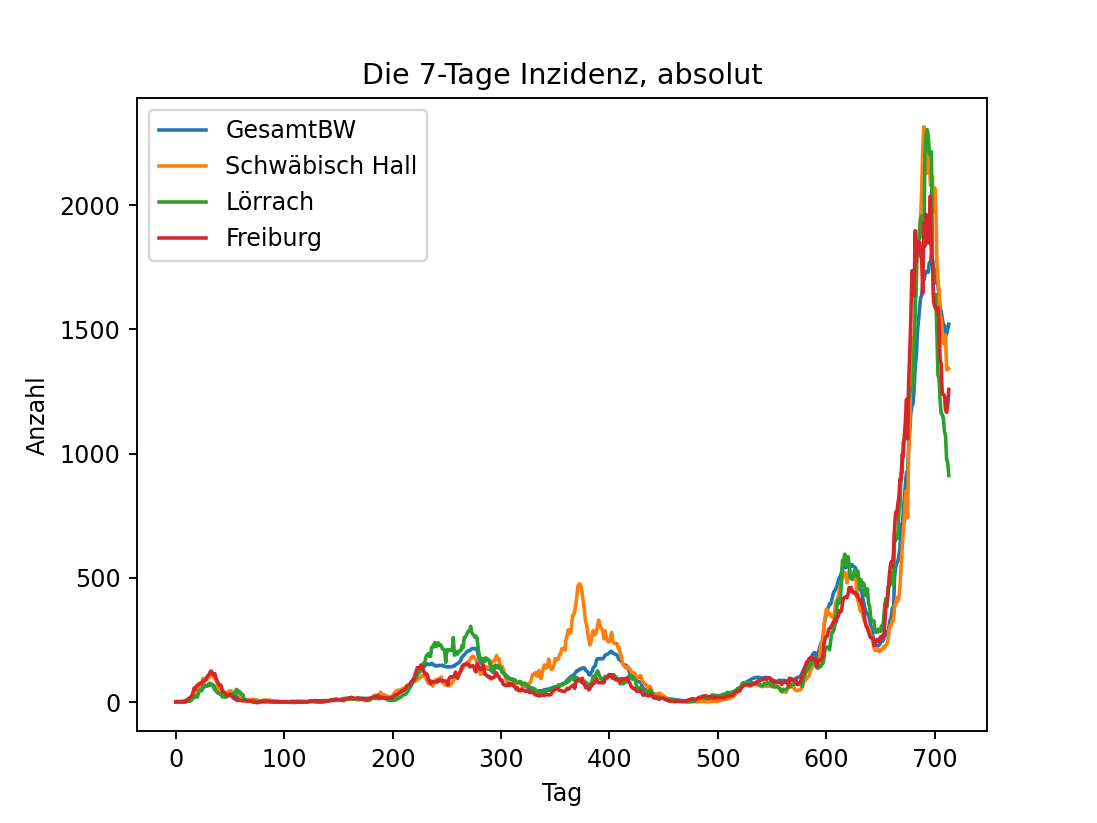

[Text(0, 0.5, 'Anzahl')]

In [73]:
%matplotlib notebook
fig, ax = plt.subplots() # initialisiere die Grafik
#
factor = 1.e5/sum(dict_EWZkreise.values()) # Gesamteinwohnerzahl BW
totalData = np.flip(sum(data_dict.values()))     # Gesamtzahl Infizierter nach Datum
ytotal = (totalData - np.roll(totalData,7))
ax.plot(factor*ytotal[7:], label='GesamtBW')
#
kreisliste = [ 'Schwäbisch Hall', 'Lörrach', 'Freiburg']   # Wähle ein paar Kreise die zu plotten willst
for kreis in kreisliste:
    keystring = keyString(kreis,data_dict) 
    factor=1.e5/dict_EWZkreise[keystring]  # Faktor 7 Tage Inzidenz
    y = np.flip(data_dict[keystring])   # Daten umdrehen
    y7 = np.roll(y,7)     # 7 Tage vorher
    y7[:8] = 0            # Erste 7 Einträge auf 0 setzen. Eigentlich nicht notwendig wenn man von 7 an plottet
    delta = y  - y7       # Differenz zwischen Eintrag und 7 Tage zuvor
    ax.plot(factor*delta[7:], label=kreis)    # Zeichnen
    #ax.plot(y, label=kreis)
#
ax.legend()
ax.set_title('Die 7-Tage Inzidenz, absolut')
ax.set(xlabel='Tag')
ax.set(ylabel='Anzahl')

# Korrelationsfunktionen

The correlation function for two signals $A(t)$ and $B(t)$ is defined as 
$$
C(t)=\lim_{\tau\rightarrow\infty}\frac{1}{\tau}\int\limits_0^\tau A(t')B(t'-t)dt'$$
Diskrete version in terms of python numpy arrays, the algorithms. Unfortunately the limit $n\rightarrow\infty$ we cannot do. So we keep a finite $n$ as the length of an array. This gives us
$$C[k]=\frac{1}{(n-k)}\sum_{i=0}^{n-k}A[i]\cdot B[i+k]$$
In order to normalize the correlation function we divide by the standard deviations of $A(t)$ and $B(t)$ to read
$$C(k\cdot\Delta\,t)=\frac{1}{(n-k)}\frac{\sum\limits_{i=0}^{n-k}A[i]\cdot B[i+k]}{S_AS_B}$$
where the standard deviations are 
$$S_A=\sqrt{\frac{1}{n-k}\sum_{i=0}^{n-k}A(i\cdot\Delta\,t)^2}$$
and
$$S_B=\sqrt{\frac{1}{n-k}\sum_{i=0}^{n-k}B(i\cdot\Delta\,t+k\cdot\Delta\,t)^2}$$

Note: Please subtract mean of every series $A$ and $B$. See below 

### We calculate the correlation function between A and B. Watch out for the correct n

<IPython.core.display.Javascript object>


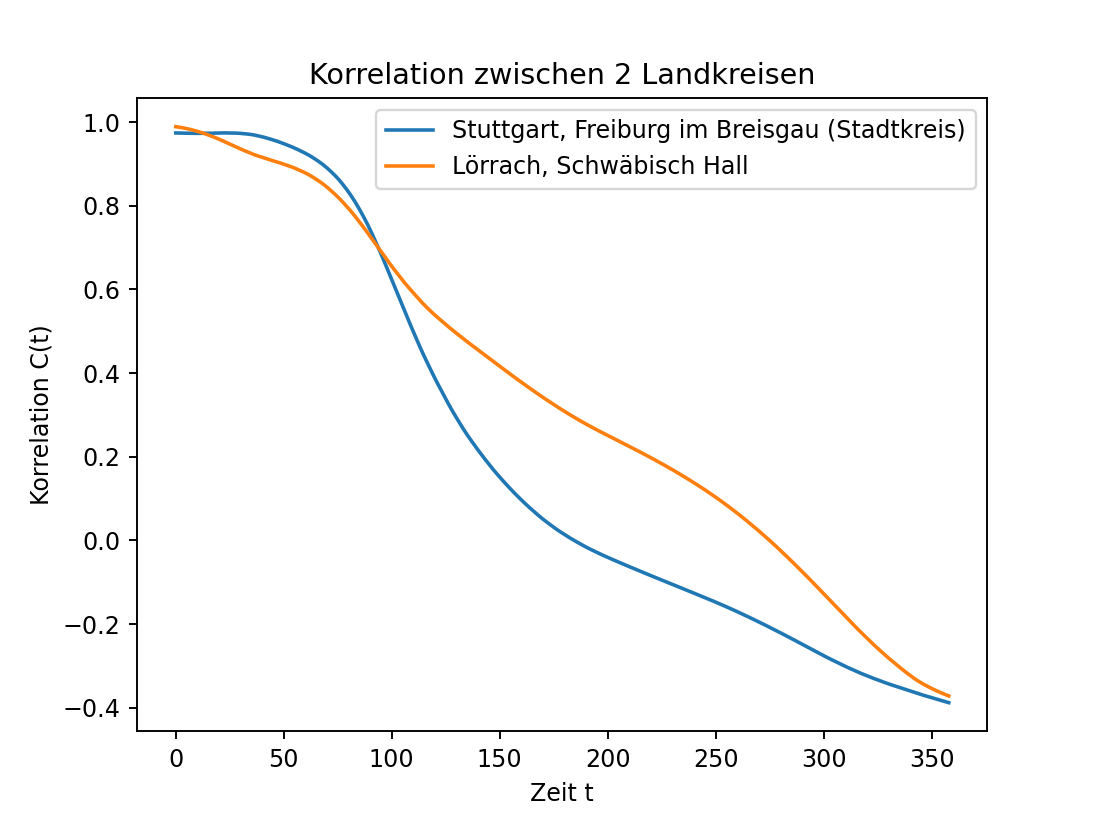

[Text(0, 0.5, 'Korrelation C(t)')]

In [63]:
%matplotlib notebook
fig, ax = plt.subplots() # initialisiere die Grafik
#
kreisA = keyString('Stuttgart',data_dict)
kreisB = keyString('Freiburg',data_dict)
A = data_dict[kreisA] # Choose dataset A
B = data_dict[kreisB] # Choose dataset B
A = A - np.mean(A) # subtract mean
B = B - np.mean(B) # subtract mean
lmax = B.shape[0]//2 # Choose the maximum value of k (see formulae above)
C = np.zeros(lmax)
S_A = np.sqrt(np.sum(A[:lmax]*A[:lmax])/lmax) # Standard deviation of A
for k in np.arange(lmax):
    D = np.roll(B, shift = -k)[:lmax] # shift and take the first lmax entries
    S_B = np.sqrt(np.sum(D*D)/lmax) # Standard deviation of B
    C[k] = np.sum(A[:lmax] * D)/lmax/S_A/S_B # The correlation function
# Note that we could just skip the division by lmax because it cancels !!!
ax.plot(C[1:], label=kreisA+', '+kreisB)
#
kreisA = keyString('Lörrach',data_dict)
kreisB = keyString('Schwäbisch Hall',data_dict)
A = data_dict[kreisA] # Choose dataset A
B = data_dict[kreisB] # Choose dataset B
A = A - np.mean(A) # subtract mean
B = B - np.mean(B) # subtract mean
lmax = B.shape[0]//2 # Choose the maximum value of k (see formulae above)
C = np.zeros(lmax)
S_A = np.sqrt(np.sum(A[:lmax]*A[:lmax])/lmax) # Standard deviation of A
for k in np.arange(lmax):
    D = np.roll(B, shift = -k)[:lmax] # shift and take the first lmax entries
    S_B = np.sqrt(np.sum(D*D)/lmax) # Standard deviation of B
    C[k] = np.sum(A[:lmax] * D)/lmax/S_A/S_B # The correlation function
# Note that we could just skip the division by lmax because it cancels !!!
ax.plot(C[1:], label=kreisA+', '+kreisB)
ax.legend()
ax.set_title('Korrelation zwischen 2 Landkreisen')
ax.set(xlabel='Zeit t')
ax.set(ylabel='Korrelation C(t)')

# Autokorrelation
Das bedeutet wir berechnen
$$
C(t)=\lim_{\tau\rightarrow\infty}\frac{1}{\tau}\int\limits_0^\tau A(t')A(t'-t)dt'$$

<IPython.core.display.Javascript object>


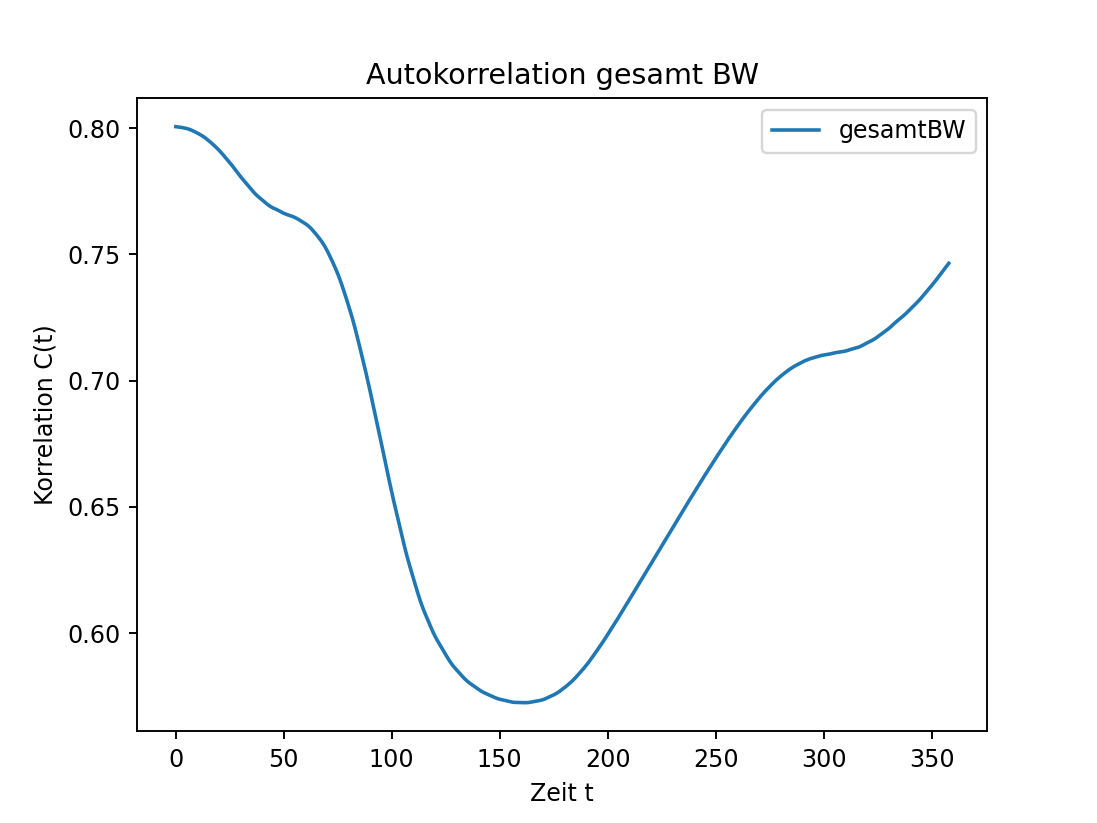

[Text(0, 0.5, 'Korrelation C(t)')]

In [88]:
%matplotlib notebook
fig, ax = plt.subplots() # initialisiere die Grafik
#
gesamtBW = sum(data_dict.values()) 
A = gesamtBW - np.mean(gesamtBW)
lmax = A.shape[0]//2 # Choose the maximum value of k (see formulae above)
C = np.zeros(lmax)
S_A = np.sqrt(np.sum(A[:lmax]*A[:lmax])/lmax) # Varianz
for k in np.arange(lmax):
    temp = np.roll(A, shift = -k)[:lmax]
    B = temp - np.mean(temp) # shift and take the first lmax entries
    S_B = np.sqrt(np.sum(B*B)/lmax) # Standard deviation of B
    #S_B = 1.0
    #S_A = 1.0
    C[k] = np.sum(A[:lmax] * B)/lmax/S_A/S_B # The correlation function
# Note that we could just skip the division by lmax because it cancels !!!
ax.plot(C[1:], label='gesamtBW')
ax.legend()
ax.set_title('Autokorrelation gesamt BW')
ax.set(xlabel='Zeit t')
ax.set(ylabel='Korrelation C(t)')

In [89]:
S_A

519923.21637451206

In [91]:
k=0
temp = np.roll(A, shift = -k)[:lmax]
B = temp - np.mean(temp) # shift and take the first lmax entries
S_B = np.sqrt(np.sum(B*B)/lmax) # Standard deviation of B
print(S_B)

416268.8168211467


In [93]:
A

array([ 1.81329560e+06,  1.78307360e+06,  1.75206060e+06,  1.72118760e+06,
        1.69305460e+06,  1.67461660e+06,  1.66278860e+06,  1.64442260e+06,
        1.61650360e+06,  1.58770360e+06,  1.55589660e+06,  1.52469960e+06,
        1.50593160e+06,  1.49127860e+06,  1.46972160e+06,  1.44035560e+06,
        1.40608560e+06,  1.36956360e+06,  1.33761260e+06,  1.31373360e+06,
        1.29806760e+06,  1.27561860e+06,  1.24299960e+06,  1.20638860e+06,
        1.17361060e+06,  1.14126260e+06,  1.12167160e+06,  1.10553360e+06,
        1.08314360e+06,  1.05225660e+06,  1.01786060e+06,  9.85729599e+05,
        9.59569599e+05,  9.41111599e+05,  9.30033599e+05,  9.12772599e+05,
        8.87503599e+05,  8.63712599e+05,  8.35831599e+05,  8.19755599e+05,
        8.07890599e+05,  7.97509599e+05,  7.83835599e+05,  7.66534599e+05,
        7.49389599e+05,  7.32499599e+05,  7.17183599e+05,  7.10370599e+05,
        7.06191599e+05,  6.98822599e+05,  6.88998599e+05,  6.69974599e+05,
        6.63555599e+05,  